# Homework 3: Gillespie Stochastic Simulation
## Problem Description
Simulate a simplified enzymatic reaction: E + S → C → E + P

- Reaction 1: E + S → C (propensity a₁ = k₁ · E · S)
- Reaction 2: C → E + P (propensity a₂ = k₂ · C)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

np.random.seed(42)

## 1. Gillespie Algorithm Implementation

In [2]:
def gillespie_simulation(k1, k2, E0, S0, C0, P0, t_max):
    E, S, C, P = E0, S0, C0, P0
    t = 0.0
    times = [t]
    states = [[E, S, C, P]]
    
    while t < t_max:
        a1 = k1 * E * S  # E + S → C
        a2 = k2 * C      # C → E + P
        a0 = a1 + a2
        if a0 == 0:
            break
        r1, r2 = np.random.rand(2)
        tau = (1.0 / a0) * np.log(1.0 / r1)
        t = t + tau
        if t > t_max:
            break
        if r2 < a1 / a0:
            # E + S → C
            E -= 1
            S -= 1
            C += 1
        else:
            # C → E + P
            C -= 1
            E += 1
            P += 1

        times.append(t)
        states.append([E, S, C, P])
    if times[-1] < t_max:
        times.append(t_max)
        states.append(states[-1])
    
    return np.array(times), np.array(states)

## 2 & 3. 运行500次模拟

In [4]:
k1 = 0.001
k2 = 0.5
E0, S0, C0, P0 = 100, 1000, 0, 0
t_max = 20.0
n_simulations = 500

all_times = []
all_S = []

for i in range(n_simulations):
    if (i + 1) % 100 == 0:
        print(f"Completed {i + 1}/{n_simulations} simulations")

    
    times, states = gillespie_simulation(k1, k2, E0, S0, C0, P0, t_max)
    all_times.append(times)
    all_S.append(states[:, 1])


Completed 100/500 simulations
Completed 200/500 simulations
Completed 300/500 simulations
Completed 400/500 simulations
Completed 500/500 simulations


## 4. Plot 10 representative trajectories

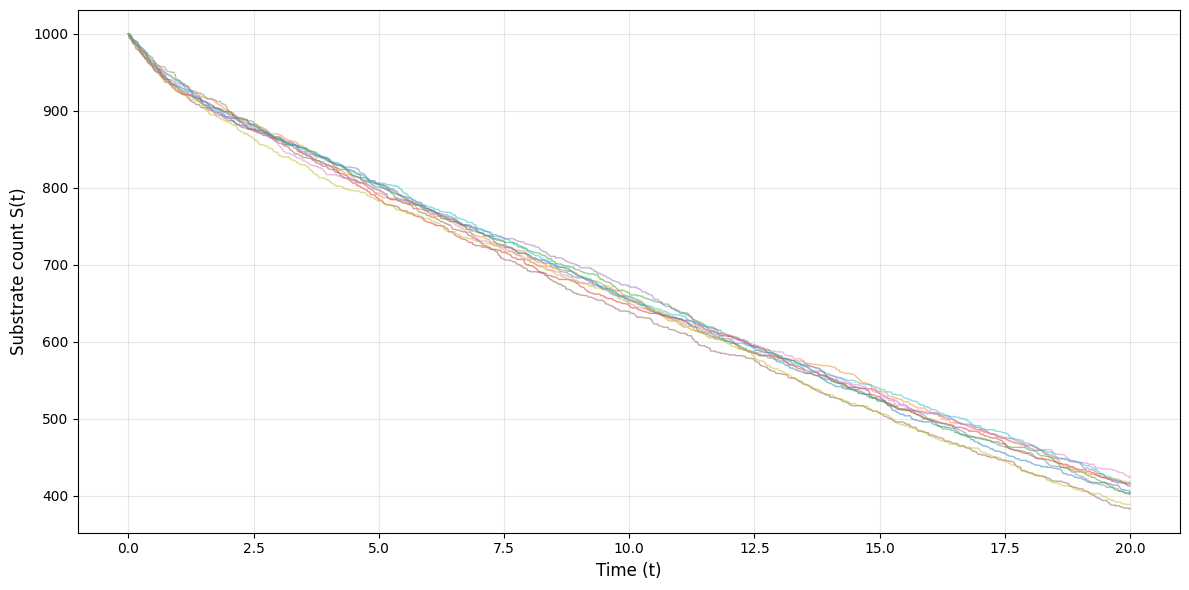

In [6]:
plt.figure(figsize=(12, 6))

n_plot = 10
indices = np.linspace(0, n_simulations - 1, n_plot, dtype=int)

for idx in indices:
    plt.plot(all_times[idx], all_S[idx], alpha=0.5, linewidth=1)

plt.xlabel('Time (t)', fontsize=12)
plt.ylabel('Substrate count S(t)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Calculate the Mean Trajectory

In [8]:
common_time_grid = np.linspace(0, t_max, 1000)

interpolated_S = np.zeros((n_simulations, len(common_time_grid)))

for i in range(n_simulations):
    f = interp1d(all_times[i], all_S[i], kind='previous', 
                 bounds_error=False, fill_value=(all_S[i][0], all_S[i][-1]))
    interpolated_S[i, :] = f(common_time_grid)

mean_S = np.mean(interpolated_S, axis=0)
std_S = np.std(interpolated_S, axis=0)
print(f"Mean trajectory calculation completed")
print(f"Initial mean S: {mean_S[0]:.2f}")
print(f"Final mean S: {mean_S[-1]:.2f}")


Mean trajectory calculation completed
Initial mean S: 1000.00
Final mean S: 406.42


## 6. Solve the Deterministic ODE Model

In [11]:
def ode_system(t, y, k1, k2):
    E, S, C, P = y
    
    dE_dt = -k1 * E * S + k2 * C
    dS_dt = -k1 * E * S
    dC_dt = k1 * E * S - k2 * C
    dP_dt = k2 * C
    
    return [dE_dt, dS_dt, dC_dt, dP_dt]

y0 = [E0, S0, C0, P0]

t_span = (0, t_max)
t_eval = common_time_grid

sol = solve_ivp(ode_system, t_span, y0, args=(k1, k2), 
                t_eval=t_eval, method='RK45', dense_output=True)

S_deterministic = sol.y[1, :]

print(f"Deterministic ODE solution completed")
print(f"Initial S: {S_deterministic[0]:.2f}")
print(f"Final S: {S_deterministic[-1]:.2f}")


Deterministic ODE solution completed
Initial S: 1000.00
Final S: 405.35


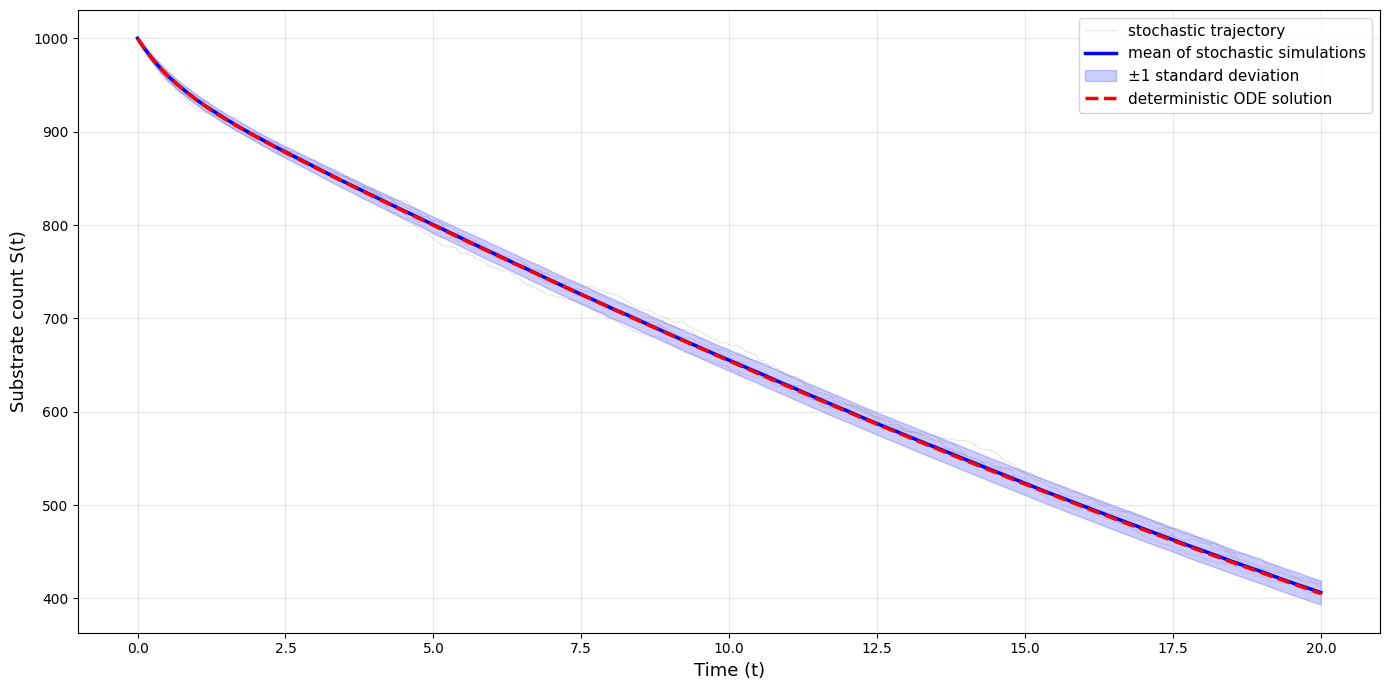

In [12]:
plt.figure(figsize=(14, 7))
for idx in indices[:5]:
    plt.plot(all_times[idx], all_S[idx], 'gray', alpha=0.2, linewidth=0.8,
             label='stochastic trajectory' if idx == indices[0] else '')

plt.plot(common_time_grid, mean_S, 'b-', linewidth=2.5, label='mean of stochastic simulations', zorder=5)
plt.fill_between(common_time_grid, mean_S - std_S, mean_S + std_S,
                 color='blue', alpha=0.2, label='±1 standard deviation')

plt.plot(common_time_grid, S_deterministic, 'r--', linewidth=2.5,
         label='deterministic ODE solution', zorder=5)

plt.xlabel('Time (t)', fontsize=13)
plt.ylabel('Substrate count S(t)', fontsize=13)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [14]:
absolute_error = np.abs(mean_S - S_deterministic)
relative_error = absolute_error / (S_deterministic + 1e-10) * 100

print("=" * 60)
print("Comparison: mean stochastic vs deterministic solution")
print("=" * 60)
print(f"Mean Absolute Error (MAE): {np.mean(absolute_error):.4f}")
print(f"Max Absolute Error: {np.max(absolute_error):.4f}")
print(f"Mean Relative Error: {np.mean(relative_error):.4f}%")
print(f"\nAt t = {t_max}:")
print(f"  Stochastic mean: {mean_S[-1]:.2f}")
print(f"  Deterministic solution: {S_deterministic[-1]:.2f}")
print(f"  Difference: {np.abs(mean_S[-1] - S_deterministic[-1]):.2f}")
print("=" * 60)


Comparison: mean stochastic vs deterministic solution
Mean Absolute Error (MAE): 0.6816
Max Absolute Error: 1.2225
Mean Relative Error: 0.1190%

At t = 20.0:
  Stochastic mean: 406.42
  Deterministic solution: 405.35
  Difference: 1.07


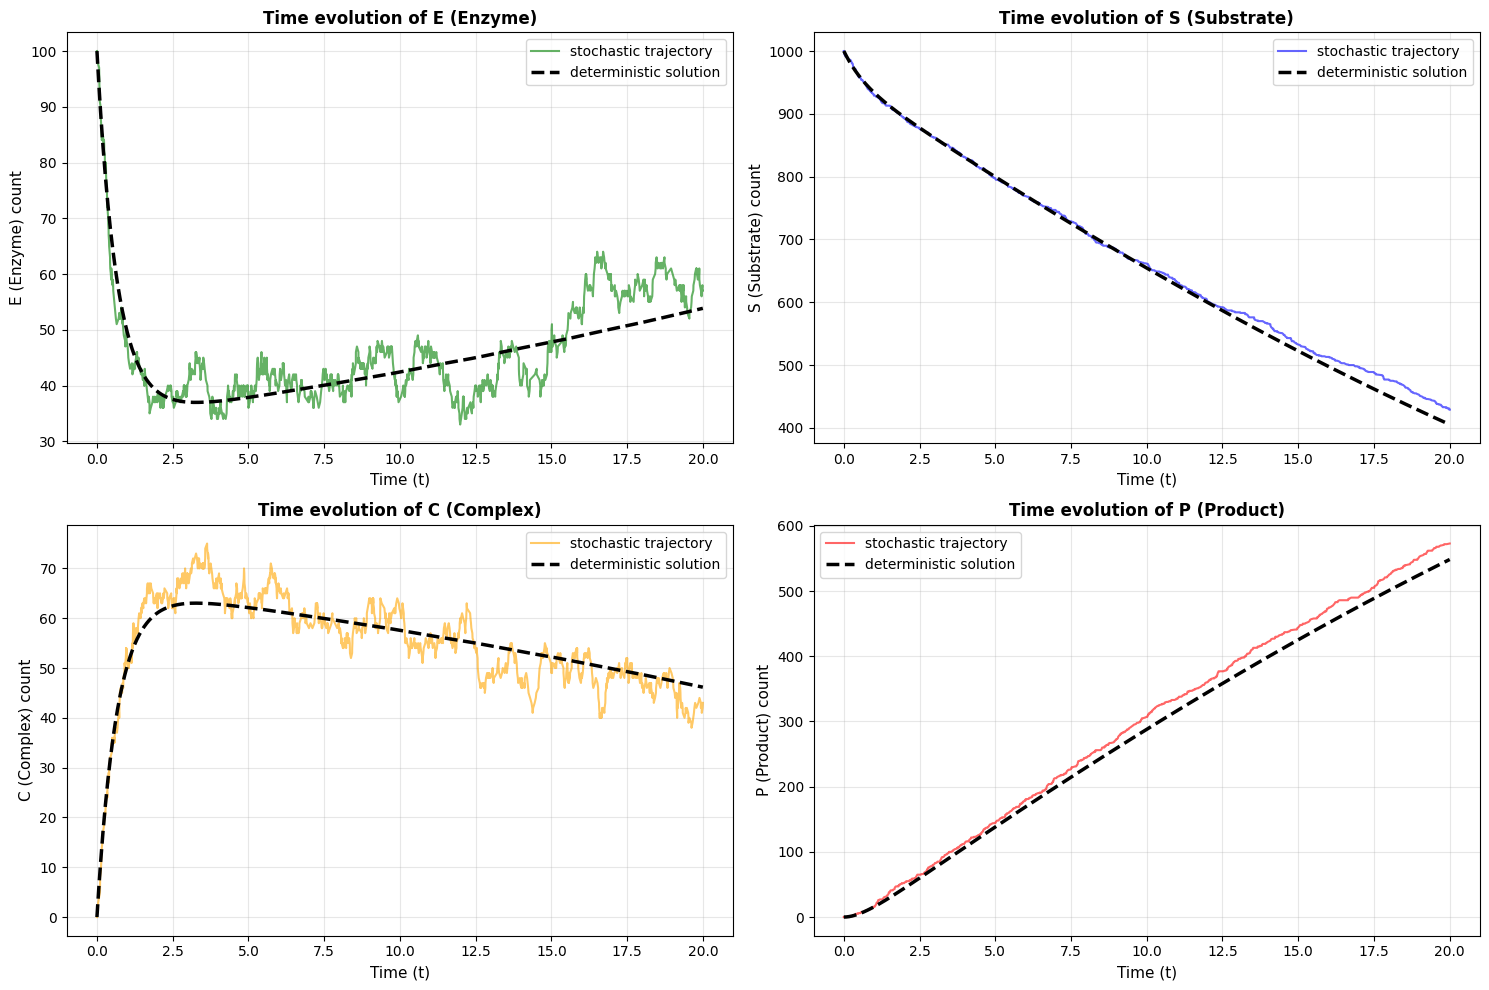

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
species_names = ['E (Enzyme)', 'S (Substrate)', 'C (Complex)', 'P (Product)']
colors = ['green', 'blue', 'orange', 'red']

for i, (ax, name, color) in enumerate(zip(axes.flat, species_names, colors)):
    times_sample, states_sample = gillespie_simulation(k1, k2, E0, S0, C0, P0, t_max)
    ax.plot(times_sample, states_sample[:, i], alpha=0.6, linewidth=1.5,
            color=color, label='stochastic trajectory')
    ax.plot(common_time_grid, sol.y[i, :], '--', linewidth=2.5,
            color='black', label='deterministic solution')
    ax.set_xlabel('Time (t)', fontsize=11)
    ax.set_ylabel(f'{name} count', fontsize=11)
    ax.set_title(f'Time evolution of {name}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Analysis and Discussion

**The results show that the mean of the stochastic simulations (blue solid line) and the deterministic ODE solution (red dashed line) are highly consistent, with the two curves almost perfectly overlapping.** This indicates that the average behavior captured by the stochastic simulations accurately reproduces the deterministic model’s predictions. In theory, this agreement arises from the **Law of Large Numbers**, where averaging many stochastic trajectories cancels out random fluctuations, making the mean converge toward the deterministic expectation described by the ODEs. The **Chemical Master Equation** underlies this relationship—while the Gillespie algorithm simulates the discrete stochastic process, the deterministic ODEs describe its expected dynamics in the **thermodynamic limit**, when molecule numbers are large (e.g., S₀ = 1000, E₀ = 100). In such systems, stochastic fluctuations are relatively small (∝ 1/√N), so deterministic models provide an excellent approximation of the mean dynamics. **In practice, this means that while individual stochastic trajectories may fluctuate, the deterministic model reliably predicts the average behavior.** For systems with small molecule counts, however, stochastic effects become non-negligible and must be explicitly modeled. Overall, the near-perfect agreement between stochastic averages and deterministic solutions confirms both the **correct implementation of the Gillespie algorithm** and the **validity of deterministic ODEs as mean-field approximations**—a theoretically expected outcome rooted in the fundamental link between stochastic chemical kinetics and their deterministic counterparts.
